# Question 2: Binary Decision-Making and Hypothesis Testing

### Research Question: for each state (NY and CA) by county, is there a significant association between temporal mobility and COVID-19 cases in 2020? (multiple hypothesis testing).

## EDA

In [29]:
# Downloading packages

!pip install pdpipe

     |████████████████████████████████| 59 kB 1.1 MB/s eta 0:00:011
  Created wheel for decore: filename=decore-0.0.1-py2.py3-none-any.whl size=4191 sha256=28e186d1029d955dcb062ac408275b5c557e274608e6d4324beb49c3fe9426da
  Stored in directory: /home/jovyan/.cache/pip/wheels/d4/39/be/a5fb8089ae58177381dc9ef9ad4fcccedcc0e8ed40ee9213f5
Successfully built decore


In [31]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pdpipe as pdp

import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
import time
from datetime import datetime

In [74]:
# Reading mobility data and dropping irrelevent columns

mobility = pd.read_csv('2020_US_Region_Mobility_Report.csv')
mobility = mobility.rename(columns = {'sub_region_2': 'County'})
mobility['date'] = pd.to_datetime(mobility['date'])
mobility = mobility.drop(['iso_3166_2_code', 'country_region_code', 'country_region', 'metro_area', 'place_id',
                                'census_fips_code'], axis = 1)
ca_mobility = mobility[mobility.sub_region_1 == "California"].dropna()
ca_mobility['County'] = ca_mobility['County'].str.replace(' County', '')
ny_mobility = mobility[mobility.sub_region_1 == "New York"].dropna()
ny_mobility['County'] = ny_mobility['County'].str.replace(' County', '')

In [75]:
ny_mobility.head()

,sub_region_1,County,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
466272,New York,Albany,2020-02-15,8.0,-4.0,45.0,4.0,0.0,0.0
466273,New York,Albany,2020-02-16,7.0,-6.0,8.0,-1.0,2.0,-1.0
466274,New York,Albany,2020-02-17,11.0,2.0,-23.0,-7.0,-41.0,9.0
466275,New York,Albany,2020-02-18,-7.0,-7.0,-33.0,0.0,-9.0,3.0
466276,New York,Albany,2020-02-19,4.0,-3.0,-21.0,2.0,-8.0,2.0


In [76]:
ca_mobility.head()

,sub_region_1,County,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
48386,California,Alameda,2020-02-15,1.0,0.0,22.0,1.0,0.0,-1.0
48387,California,Alameda,2020-02-16,7.0,0.0,24.0,5.0,1.0,-2.0
48388,California,Alameda,2020-02-17,13.0,1.0,55.0,-31.0,-53.0,11.0
48389,California,Alameda,2020-02-18,-2.0,3.0,21.0,3.0,0.0,0.0
48390,California,Alameda,2020-02-19,-1.0,0.0,14.0,1.0,0.0,0.0


In [77]:
# Reading data for confirmed cases, deaths and recoveries for COVID-19 in CA

ca_cases = pd.read_csv("ca_cases.csv")
ca_cases = ca_cases[['date', 'area', 'positive_tests', 'cumulative_positive_tests', 'total_tests', 
                    'cumulative_total_tests']]
ca_cases['date'] = pd.to_datetime(ca_cases['date'])
ca_cases = ca_cases.rename(columns = {'area': 'County'}).dropna()

ca_cases = ca_cases[ca_cases['date'] < datetime(year=2021, month=1, day=1)]
ca_cases.head()

,date,County,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,2020-02-01,Alameda,0.0,0,4.0,4
1,2020-02-01,Stanislaus,0.0,0,1.0,1
2,2020-02-01,Alpine,0.0,0,0.0,0
3,2020-02-01,Sonoma,0.0,0,0.0,0
4,2020-02-01,Amador,0.0,0,0.0,0


In [78]:
# Reading data for confirmed cases, deaths and recoveries for COVID-19 in NY

ny_cases = pd.read_csv("New_York_State_Statewide_COVID-19_Testing.csv")
ny_cases = ny_cases.rename(columns = {'Test Date': 'date', 'New Positives': 'positive_tests',
                                     'Cumulative Number of Positives': 'cumulative_positive_tests',
                                     'Total Number of Tests Performed': 'total_tests',
                                     'Cumulative Number of Tests Performed': 'cumulative_total_tests'}).dropna()
ny_cases['date'] = pd.to_datetime(ny_cases['date'])
ny_cases = ny_cases[ny_cases['date'] < datetime(year=2021, month=1, day=1)]
ny_cases.head()

,date,County,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,2020-03-01,Albany,0,0,0,0
1,2020-03-02,Albany,0,0,0,0
2,2020-03-03,Albany,0,0,0,0
3,2020-03-04,Albany,0,0,0,0
4,2020-03-05,Albany,0,0,3,3


In [88]:
ca_data = pd.merge(ca_mobility, ca_cases,  how = 'inner', left_on = ['date','County'], right_on = ['date','County'])
ca_data = ca_data.rename(columns = {'sub_region_1': 'state'})
ca_data = ca_data.sort_values('date')
ca_data.head()

,state,County,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,California,Alameda,2020-02-15,1.0,0.0,22.0,1.0,0.0,-1.0,0.0,0,0.0,9
10866,California,Yolo,2020-02-15,2.0,3.0,11.0,12.0,-1.0,-1.0,0.0,0,0.0,0
956,California,Fresno,2020-02-15,4.0,0.0,24.0,8.0,-5.0,0.0,0.0,2,0.0,57
10545,California,Ventura,2020-02-15,1.0,-2.0,7.0,-1.0,-1.0,0.0,0.0,0,1.0,3
1278,California,Humboldt,2020-02-15,9.0,-1.0,56.0,-27.0,-2.0,-1.0,0.0,0,0.0,0


In [89]:
ny_data = pd.merge(ny_mobility, ny_cases,  how = 'inner', left_on = ['date','County'], right_on = ['date','County'])
ny_data = ny_data.rename(columns = {'sub_region_1': 'state'})
ny_data = ny_data.sort_values('date')
ny_data.head()

,state,County,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,positive_tests,cumulative_positive_tests,total_tests,cumulative_total_tests
0,New York,Albany,2020-03-01,10.0,13.0,19.0,4.0,7.0,-1.0,0,0,0,0
4905,New York,Suffolk,2020-03-01,3.0,3.0,5.0,1.0,5.0,0.0,0,0,0,0
4809,New York,Schenectady,2020-03-01,18.0,9.0,-2.0,9.0,6.0,-1.0,0,0,0,0
4573,New York,Saratoga,2020-03-01,11.0,8.0,-2.0,16.0,6.0,-1.0,0,0,0,0
4305,New York,Rockland,2020-03-01,8.0,-1.0,10.0,14.0,5.0,-1.0,0,0,0,0


Text(0.5, 1.0, 'New Cases Against % Change in Retail and Recreation Mobility (CA)')

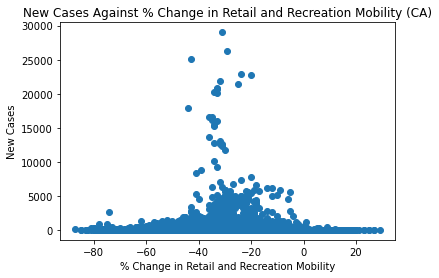

In [127]:
plt.scatter(ca_data['retail_and_recreation_percent_change_from_baseline'], ca_data['positive_tests'])
plt.xlabel('% Change in Retail and Recreation Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Retail and Recreation Mobility (CA)')

Text(0.5, 1.0, 'New Cases Against % Change in Retail and Recreation Mobility (NY)')

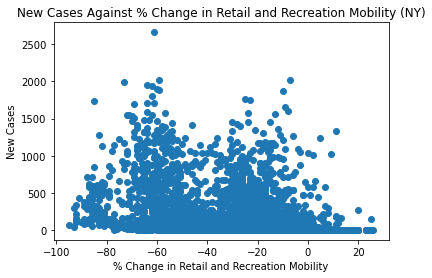

In [126]:
plt.scatter(ny_data['retail_and_recreation_percent_change_from_baseline'], ny_data['positive_tests'])
plt.xlabel('% Change in Retail and Recreation Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Retail and Recreation Mobility (NY)')

Text(0.5, 1.0, 'New Cases Against % Change in Grocery and Pharmacy Mobility (CA)')

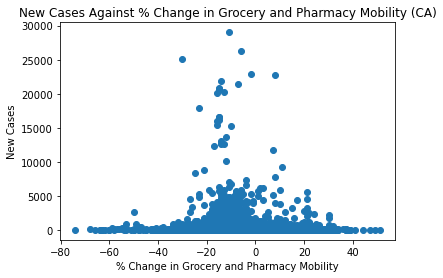

In [125]:
plt.scatter(ca_data['grocery_and_pharmacy_percent_change_from_baseline'], ca_data['positive_tests'])
plt.xlabel('% Change in Grocery and Pharmacy Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Grocery and Pharmacy Mobility (CA)')

Text(0.5, 1.0, 'New Cases Against % Change in Grocery and Pharmacy Mobility (NY)')

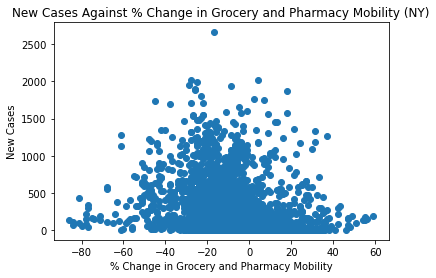

In [124]:
plt.scatter(ny_data['grocery_and_pharmacy_percent_change_from_baseline'], ny_data['positive_tests'])
plt.xlabel('% Change in Grocery and Pharmacy Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Grocery and Pharmacy Mobility (NY)')

Text(0.5, 1.0, 'New Cases Against % Change in Park Mobility (CA)')

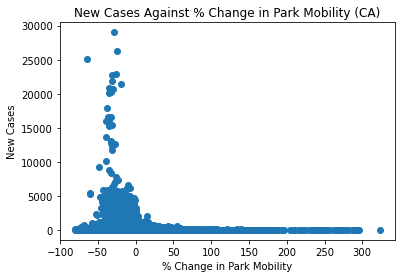

In [105]:
plt.scatter(ca_data['parks_percent_change_from_baseline'], ca_data['positive_tests'])
plt.xlabel('% Change in Park Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Park Mobility (CA)')

Text(0.5, 1.0, 'New Cases Against % Change in Park Mobility (NY)')

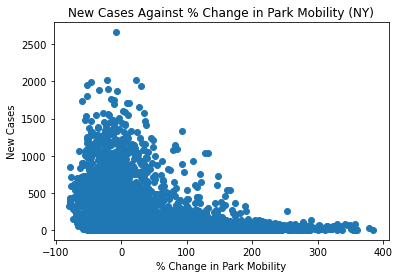

In [100]:
plt.scatter(ny_data['parks_percent_change_from_baseline'], ny_data['positive_tests'])
plt.xlabel('% Change in Park Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Park Mobility (NY)')

Text(0.5, 1.0, 'New Cases Against % Change in Transit Station Mobility (CA)')

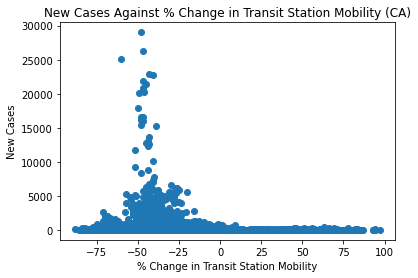

In [106]:
plt.scatter(ca_data['transit_stations_percent_change_from_baseline'], ca_data['positive_tests'])
plt.xlabel('% Change in Transit Station Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Transit Station Mobility (CA)')

Text(0.5, 1.0, 'New Cases Against % Change in Transit Station Mobility (NY)')

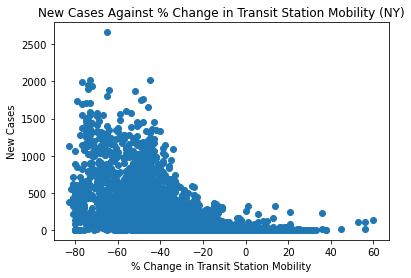

In [101]:
plt.scatter(ny_data['transit_stations_percent_change_from_baseline'], ny_data['positive_tests'])
plt.xlabel('% Change in Transit Station Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Transit Station Mobility (NY)')

Text(0.5, 1.0, 'New Cases Against % Change in Workplace Mobility (CA)')

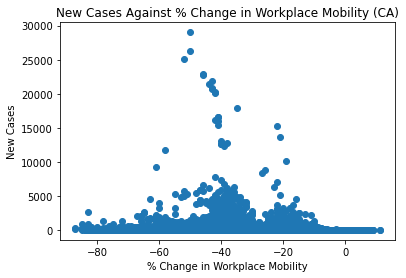

In [107]:
plt.scatter(ca_data['workplaces_percent_change_from_baseline'], ca_data['positive_tests'])
plt.xlabel('% Change in Workplace Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Workplace Mobility (CA)')

Text(0.5, 1.0, 'New Cases Against % Change in Workplace Mobility (NY)')

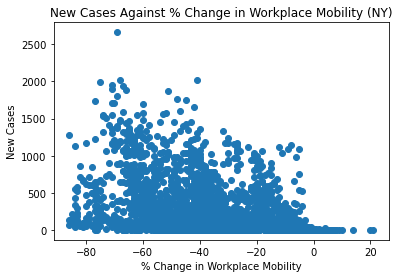

In [102]:
plt.scatter(ny_data['workplaces_percent_change_from_baseline'], ny_data['positive_tests'])
plt.xlabel('% Change in Workplace Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Workplace Mobility (NY)')

Text(0.5, 1.0, 'New Cases Against % Change in Residential Mobility (CA)')

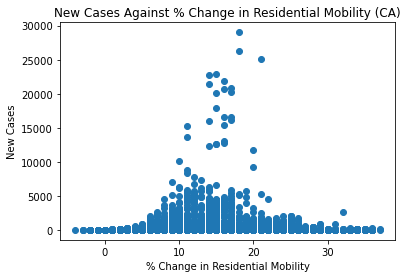

In [108]:
plt.scatter(ca_data['residential_percent_change_from_baseline'], ca_data['positive_tests'])
plt.xlabel('% Change in Residential Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Residential Mobility (CA)')

Text(0.5, 1.0, 'New Cases Against % Change in Residential Mobility (NY)')

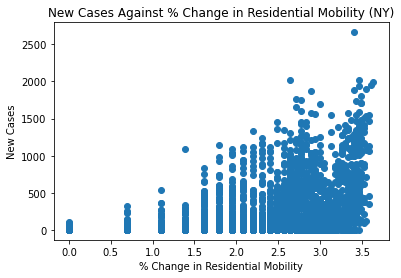

In [116]:
plt.scatter(np.log(ny_data['residential_percent_change_from_baseline']), ny_data['positive_tests'])
plt.xlabel('% Change in Residential Mobility')
plt.ylabel('New Cases')
plt.title('New Cases Against % Change in Residential Mobility (NY)')